In [1]:
import csv
import nltk
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from tensorflow.keras import Sequential
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Flatten, Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import MaxPooling2D,Conv2D, Conv1D, MaxPooling1D

STOPWORDS = set(stopwords.words('english'))


print(tf.__version__)

2.3.1


In [2]:
vocab_size = 9000
embedding_dim = 64
max_length = 90
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [3]:
dataset = pd.read_csv("bible_data_set (with count and testament).csv")
col = ['book', 'text']
dataset= dataset[col]

dataset.dropna(subset=["text"], inplace=True)
dataset.columns=['book', 'text']

dataset.head()

,book,text
0,Genesis,In the beginning God created the heaven and th...
1,Genesis,"And the earth was without form, and void; and ..."
2,Genesis,"And God said, Let there be light: and there wa..."
3,Genesis,"And God saw the light, that it was good: and G..."
4,Genesis,"And God called the light Day, and the darkness..."


In [4]:
print(dataset["text"].to_list()[:5])

original_text = dataset["text"].to_list()[:30]

['In the beginning God created the heaven and the earth. \n', 'And the earth was without form, and void; and darkness was upon the face of the deep. And the Spirit of God moved upon the face of the waters. \n', 'And God said, Let there be light: and there was light. \n', 'And God saw the light, that it was good: and God divided the light from the darkness. \n', 'And God called the light Day, and the darkness he called Night. And the evening and the morning were the first day. \n']


In [5]:
stemmer = PorterStemmer()

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
REMOVE_NUM = re.compile('[\d+]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
    text: a string
    return: modified initial string
    """
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = text.replace('x', '') 
    text = REMOVE_NUM.sub('', text)
    text = BAD_SYMBOLS_RE.sub('', text) 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    text = ' '.join(word for word in text.split() if (len(word) >= 2 and len(word) <= 21))
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    
    return text

In [6]:
dataset["text"] = dataset["text"].apply(clean_text)
dataset["text"]

0                             begin god creat heaven earth
1        earth without form void dark upon face deep sp...
2                                 god said let light light
3                  god saw light good god divid light dark
4        god call light day dark call night even morn f...
                               ...                        
31097    spirit bride say come let heareth say come let...
31098    testifi unto everi man heareth word propheci b...
31099    man shall take away word book propheci god sha...
31100    testifieth thing saith sure come quickli amen ...
31101                          grace lord jesu christ amen
Name: text, Length: 31102, dtype: object

In [7]:
dataset = dataset.sample(frac=1)
dataset

,book,text
2191,Exodus,said unto elder tarri ye us come unto behold a...
3074,Leviticus,spread much abroad skin priest shall pronounc ...
12782,Esther,said king unto wilt thou queen esther thi requ...
18105,Isaiah,citi confus broken everi hous shut man may come
9565,2 Kings,took mantl elijah fell smote water said lord g...
...,...,...
13045,Job,green sun branch shooteth forth garden
9783,2 Kings,ahaziah king judah saw fled way garden hous je...
12846,Esther,king said unto esther queen jew slain destroy ...
15119,Psalms,gener come might know even children born aris ...


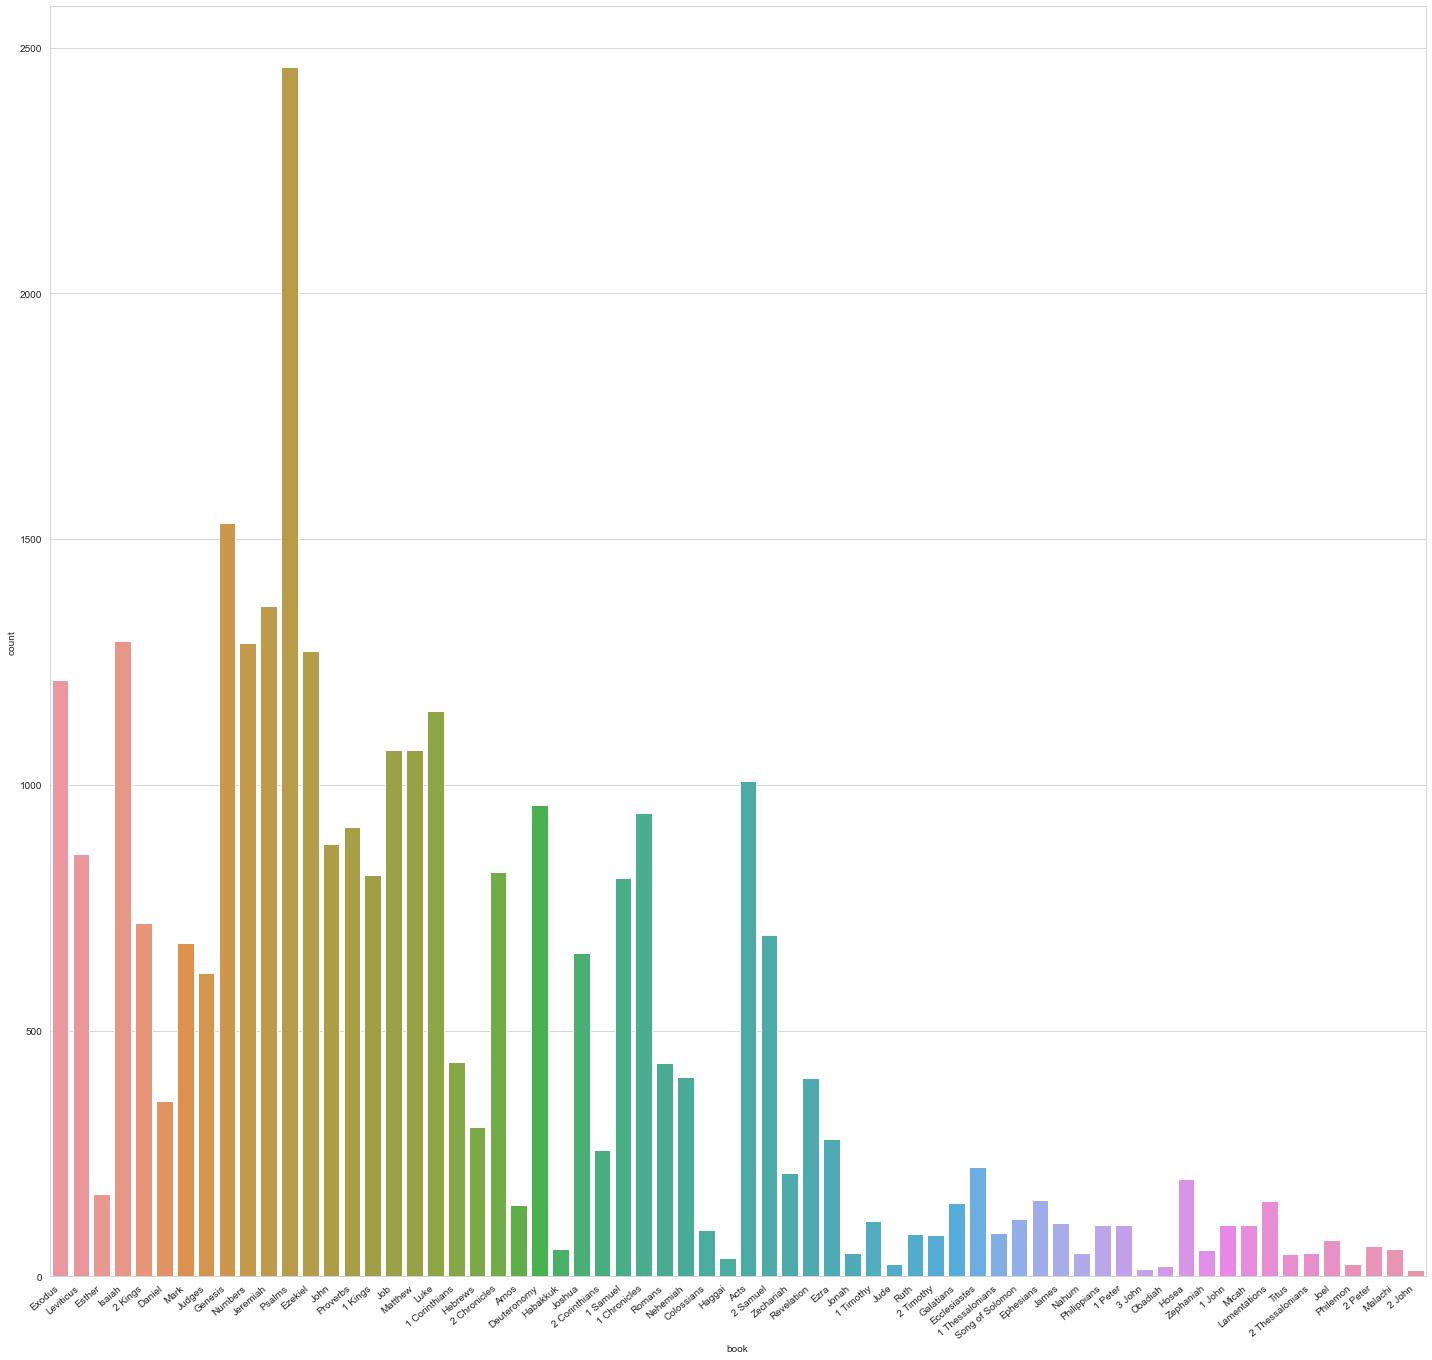

In [8]:
sns.set_style('whitegrid')
plt.figure(figsize=(20, 19))
ax = sns.countplot(x='book', data=dataset)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

In [9]:
verses = dataset["text"].values
labels = dataset[["book"]].values

X_train, y_train, X_test, y_test = train_test_split(verses,labels, test_size = 0.20, random_state = 42)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(24881,) (24881, 1)
(6221,) (6221, 1)


In [10]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(dict(list(word_index.items())[0:10]))

train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_seq = tokenizer.texts_to_sequences(y_train)
validation_padded = pad_sequences(validation_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print('Shape of data tensor:', train_padded.shape)
print('Shape of data tensor:', validation_padded.shape)


Found 8572 unique tokens.
{'<OOV>': 1, 'shall': 2, 'unto': 3, 'lord': 4, 'thou': 5, 'god': 6, 'thi': 7, 'ye': 8, 'said': 9, 'thee': 10}
Shape of data tensor: (24881, 90)
Shape of data tensor: (6221, 90)


In [11]:
encode = OneHotEncoder()

training_labels = encode.fit_transform(X_test)
validation_labels = encode.transform(y_test)
print(training_labels)

  (0, 29)	1.0
  (1, 39)	1.0
  (2, 34)	1.0
  (3, 34)	1.0
  (4, 58)	1.0
  (5, 43)	1.0
  (6, 25)	1.0
  (7, 53)	1.0
  (8, 26)	1.0
  (9, 43)	1.0
  (10, 4)	1.0
  (11, 43)	1.0
  (12, 20)	1.0
  (13, 13)	1.0
  (14, 3)	1.0
  (15, 58)	1.0
  (16, 19)	1.0
  (17, 25)	1.0
  (18, 59)	1.0
  (19, 0)	1.0
  (20, 3)	1.0
  (21, 39)	1.0
  (22, 48)	1.0
  (23, 13)	1.0
  (24, 2)	1.0
  :	:
  (24856, 57)	1.0
  (24857, 50)	1.0
  (24858, 34)	1.0
  (24859, 52)	1.0
  (24860, 5)	1.0
  (24861, 37)	1.0
  (24862, 46)	1.0
  (24863, 18)	1.0
  (24864, 25)	1.0
  (24865, 58)	1.0
  (24866, 0)	1.0
  (24867, 48)	1.0
  (24868, 52)	1.0
  (24869, 40)	1.0
  (24870, 37)	1.0
  (24871, 59)	1.0
  (24872, 0)	1.0
  (24873, 20)	1.0
  (24874, 26)	1.0
  (24875, 49)	1.0
  (24876, 25)	1.0
  (24877, 26)	1.0
  (24878, 46)	1.0
  (24879, 18)	1.0
  (24880, 48)	1.0


In [12]:
print(train_padded.shape)
print(validation_labels.shape)
print(validation_padded.shape)
print(training_labels.shape)
print(type(train_padded))
print(type(validation_padded))
print(type(training_labels))
print(type(validation_labels))

training_labels = training_labels.toarray()
validation_labels = validation_labels.toarray()

print(type(training_labels))
print(type(validation_labels))

(24881, 90)
(6221, 66)
(6221, 90)
(24881, 66)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [13]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))
model.add(Conv1D(64, 32, activation='relu', padding='valid'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(66, activation='softmax'))

# model.add(Conv1D(filters=16, kernel_size=5,activation='relu',input_shape=(9421,1)))
# model.add(MaxPooling1D(pool_size=1))
# model.add(Dropout(rate = 0.6))
# model.add(Conv1D(16, kernel_size=5, activation='relu'))
# model.add(MaxPooling1D(pool_size=1))
# model.add(Dropout(rate = 0.6))
# model.add(Flatten())
# model.add(Dense(66, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 90, 64)            576000    
_________________________________________________________________
conv1d (Conv1D)              (None, 59, 64)            131136    
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 66)                4

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 100
batch_size = 128

history = model.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    validation_split=0.2,
                    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001), 
                               EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1),
                               EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)])

Epoch 1/100
156/156 [==============================] - 8s 54ms/step - loss: 3.9110 - accuracy: 0.0545 - val_loss: 3.6567 - val_accuracy: 0.1079
Epoch 2/100
156/156 [==============================] - 8s 52ms/step - loss: 3.6279 - accuracy: 0.0942 - val_loss: 3.3737 - val_accuracy: 0.1571
Epoch 3/100
156/156 [==============================] - 8s 52ms/step - loss: 3.3252 - accuracy: 0.1521 - val_loss: 3.0363 - val_accuracy: 0.2552
Epoch 4/100
156/156 [==============================] - 8s 52ms/step - loss: 3.0240 - accuracy: 0.2077 - val_loss: 2.7864 - val_accuracy: 0.2933
Epoch 5/100
156/156 [==============================] - 8s 52ms/step - loss: 2.8050 - accuracy: 0.2444 - val_loss: 2.6456 - val_accuracy: 0.3201
Epoch 6/100
156/156 [==============================] - 8s 53ms/step - loss: 2.6695 - accuracy: 0.2692 - val_loss: 2.5626 - val_accuracy: 0.3359
Epoch 7/100
156/156 [==============================] - 8s 52ms/step - loss: 2.5506 - accuracy: 0.2938 - val_loss: 2.4943 - val_accuracy:

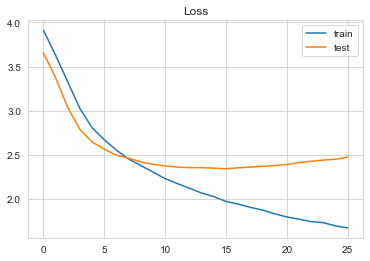

In [22]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

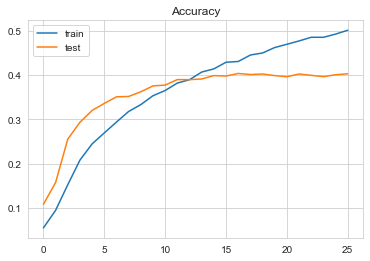

In [23]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [24]:
def evaluate_preds(y_true, y_preds):
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='micro')
    recall = recall_score(y_true, y_preds, average='micro')
    f1 = f1_score(y_true, y_preds, average='micro')
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

In [25]:
predicted = model.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))

Acc: 40.28%
Precision: 0.40
Recall: 0.40
F1 score: 0.40


{'accuracy': 0.4, 'precision': 0.4, 'recall': 0.4, 'f1': 0.4}

In [26]:
import sklearn.metrics as metrics
print(metrics.classification_report(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1), 
                                    target_names=dataset['book'].unique()))

                 precision    recall  f1-score   support

         Exodus       0.46      0.42      0.44       178
      Leviticus       0.16      0.46      0.23        81
         Esther       0.00      0.00      0.00        24
         Isaiah       0.41      0.39      0.40       166
        2 Kings       0.00      0.00      0.00        23
         Daniel       0.80      0.59      0.68       150
           Mark       0.00      0.00      0.00        13
         Judges       0.00      0.00      0.00        18
        Genesis       0.32      0.39      0.35       163
        Numbers       0.00      0.00      0.00        61
       Jeremiah       0.00      0.00      0.00         2
         Psalms       0.44      0.28      0.34       150
        Ezekiel       0.00      0.00      0.00        16
           John       0.47      0.56      0.51       135
       Proverbs       0.00      0.00      0.00        11
        1 Kings       0.00      0.00      0.00        16
            Job       0.00    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


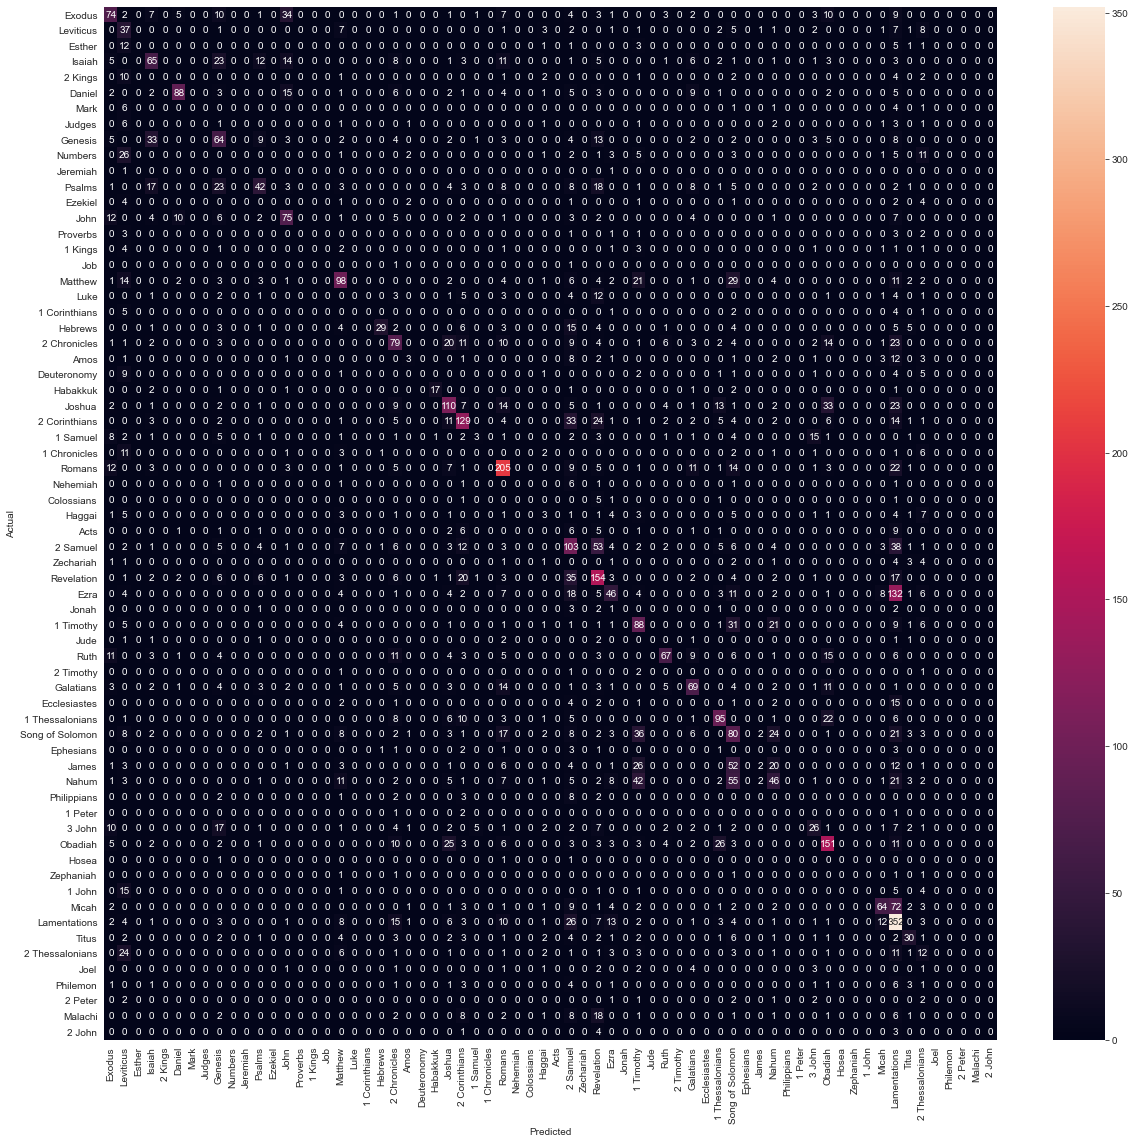

In [27]:
conf_mat = confusion_matrix(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))
fig, ax = plt.subplots(figsize=(20,19))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=dataset.book.unique(), yticklabels=dataset.book.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [28]:
verse = "Solomon gave orders to build a temple for the Name of the LORD and a royal palace for himself."
new_verse = [clean_text(verse)]
print(verse)
print(new_verse)
seq = tokenizer.texts_to_sequences(new_verse)
padded = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
pred = model.predict(padded)

acc = model.predict_proba(padded)
predicted_label = encode.inverse_transform(pred)
print('')
print(f'book : {np.argmax(pred[0])}')
print(f'Predicted label is: {predicted_label[0]}')
print(f'Accuracy score: { acc.max() * 100}')

Solomon gave orders to build a temple for the Name of the LORD and a royal palace for himself.
['solomon gave order build templ name lord royal palac']

book : 8
Predicted label is: ['2 Chronicles']
Accuracy score: 13.509595394134521
